# Prompts

so im using the DISFA+ dataset for ActionUnit detection and multiple classification of AU (action unit)
heres the readme for the original dataset:

Extended DISFA (DISFA+) Dataset Overview 

Analyzing facial expressions has been an active research topic in the past two decades. There are several datasets, which provide set of ground-truthed data for either posed (non-genuine) and spontaneous (genuine) facial expressions. There are few datasets that provide annotations of prototypic facial expressions of emotions. However some provide the annotation of facial expressions for AUs described FACS.  

In our previously released dataset, DISFA (Denver Intensity of Spontaneous Actions), we’ve releases (images and facial landmarks) of spontaneous facial expressions of 27 subjects and the intensity of twelve facial actions in 5-level of intensity. After large world wide positive feedback, we’ve been inspired to capture and annotate the intensity of AUs for posed expressions as well. This new dataset, is called Extended DISFA (DISFA+), where AU intensity of posed facial actions for a subset of DISFA subjects dataset has been annotated and publicly released. 

 

Extended DISFA (DISFA+) Dataset: 

Extended DISFA dataset (or DISFA+) provides the posed facial expression of 9 subjects out of 27 subjects of DISFA dataset. DISFA+ contains the list of 42 posed facial actions. For every frame in DISFA+, the intensity of facial action units (AUs) was annotated by an expert FACS expert. DISFA+ contains, 

Forty-two posed facial expressions data for 9 Subjects (See Figure 3) 

Manually labeled frame-based annotations in 5-level intensity of twelve FACS facial actions (See Table 1). 

Landmark point as the metadata files which  [i.e. 200x200 pixel cropped faces with the facial landmark points as MATLAB (.mat) file] (See Figure 2) 

NOTES: 

WE ARE ONLY USING THE 1ST SUBJECT FOR OUR WORK RIGHT NOW so subjects in disfa+ can be ignored 



The dataset has a file structure like this:

DISFA (main folder containing 3 folders: images, labels and facial landmarks)

- Images (folder 1) 
- - A1_AU1_TrailNo_1 (folder containing images from 000.jpg to 147.jpg)
- - A1_AU1_TrailNo_2 (folder containing images  from 000.jpg to 109.jpg)
- - A2_AU1_TrailNo_1 (folder containing images ...)
.....
- - Z_SupriseText_TrailNo_2 (folder containing images ...)

- Labels (folder 2)
- - A1_AU1_TrailNo_1 (folder containing labels of AU)
- - - AU1.txt (text file containing the label information for each image in the subfolder)
- - - AU4.txt
- - - AU26.txt 
- - - ...
- - A1_AU1_TrailNo_2 (folder containing labels of AU)
- - - AU3.txt 
- - - AU10.txt
- - - AU22.txt 
- - - ...
- - A2_AU1_TrailNo_1(folder containing labels of AU)
.....
- - Z_SupriseText_TrailNo_2 (folder containing labels of AU)

- FaceLandmarks (folder 3)
- - A1_AU1_TrailNo_1_FaceCropped.mat
- - A1_AU1_TrailNo_2_FaceCropped.mat
- - A2_AU1_TrailNo_1_FaceCropped.mat
.....
- - Z_SupriseText_TrailNo_2_FaceCropped.mat

Extra information:
The images in each sub-folder in the 'image' folder are named from 000.jpg, 001.jpg ... etc; All the subfolders inside the 'image' folder contain different amount of images in each subfolder.

The 'labels' folder contains the AU(number).txt files (multiple txt files, all for different AU labels) 

The subfolder in labels folder are all the same name as the ones in image folder. 
Each subfolder had a set of AU(number).txt files that differ from every subfolder and it contains information of that particulat AU being present in the images of that subfolder.

the content of the txt files is filled like this:
(example AU1.txt for 1st subfolder)
\# FrameID--Annotation 
\# ~~~~~~~~~~~~~~~~~~~~~~~
000.jpg     0
001.jpg     1
002.jpg     0
003.jpg     0
004.jpg     1
005.jpg     0
006.jpg     0
...........
147.jpg     1

which displays that this AU(number) class is present in which image in the folder set.


I want you to refer the filestructure i gave to you and write me a pytorch code to reach this data for multiple classification (one input image will have several AU classes)

# Dev

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class DISFADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load all samples into a list
        for img_folder in sorted(os.listdir(os.path.join(root_dir, 'Images'))):
            images = [Image.open(os.path.join(root_dir, 'Images', img_folder, f'{i:03d}.jpg')).convert('RGB') for i in range(len(os.listdir(os.path.join(root_dir, 'Images', img_folder))))]

            labels = {}
            labels_folder = os.path.join(root_dir, 'Labels', img_folder)
            for au_file in os.listdir(labels_folder):
                au, _ = os.path.splitext(au_file)
                au_data = torch.from_numpy(
                    np.loadtxt(os.path.join(labels_folder, au_file), dtype=np.float32, skiprows=2, usecols=1)
                ).long()
                labels[au] = au_data

            self.samples.append((images, labels))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        images, labels = self.samples[idx]

        if self.transform:
            images = [self.transform(img) for img in images]

        images = torch.stack(images, dim=0)

        return images, labels

# Assuming you have a transform for normalization, resizing, etc.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [2]:
# Replace 'path/to/your/DISFA' with the actual path to your DISFA dataset
dataset = DISFADataset(root_dir=r"C:\Users\KARAN\Desktop\Cambridge\LibreFace\data\DISFA", transform=transform)

# Create DataLoader for training
#train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [3]:
# # Example of accessing the dataset
# for i in range(len(dataset)):
#     sample = dataset[i]
#     images, labels = sample
#     print(images.shape, labels.keys())

In [4]:
import torch


# Initialize empty lists to store individual samples
X_list = []
Y_list = []

# Iterate through the dataset
for i in range(len(dataset)):
    sample = dataset[i]
    images, labels = sample

    # Append individual samples to the lists
    X_list.append(images)
    Y_list.append(torch.stack(list(labels.values()), dim=1))  # Concatenate label tensors along dim=1

# Concatenate the lists to create the final tensors
X = torch.cat(X_list, dim=0)
Y = torch.cat(Y_list, dim=0)

# Print the shapes
print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: torch.Size([6576, 3, 224, 224])
Y shape: torch.Size([6576, 12])


In [5]:
# Displaying the 12 labels in Y
labels = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']

# for i in range(12):
#     print(f"{labels[i]}: {Y[:, i]}")


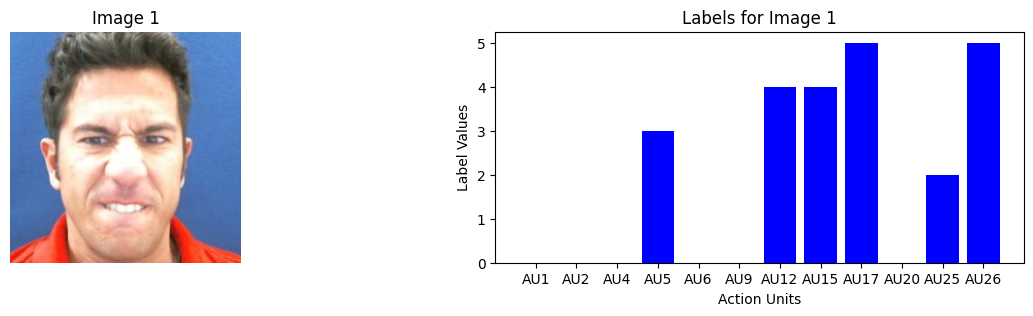

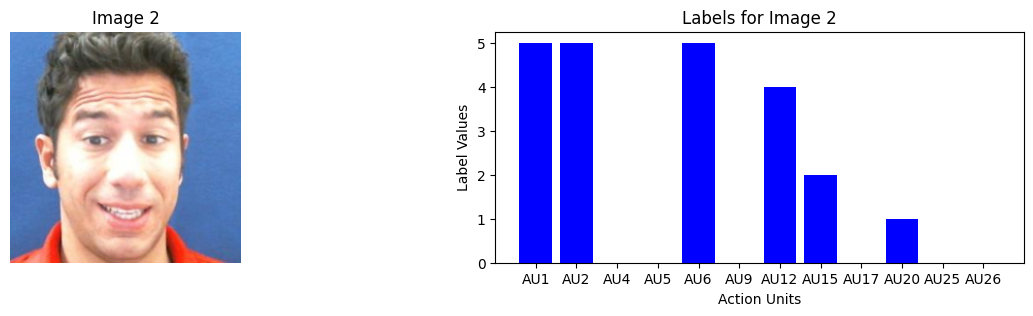

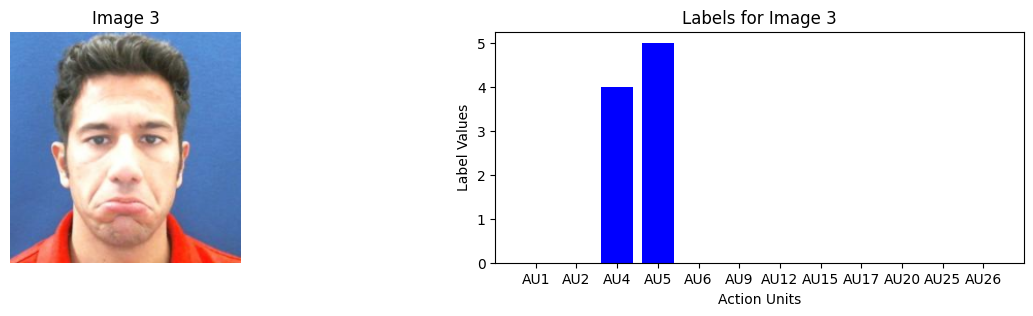

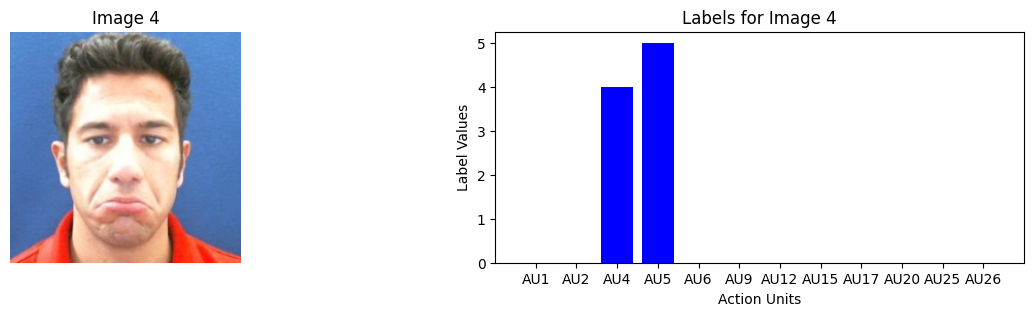

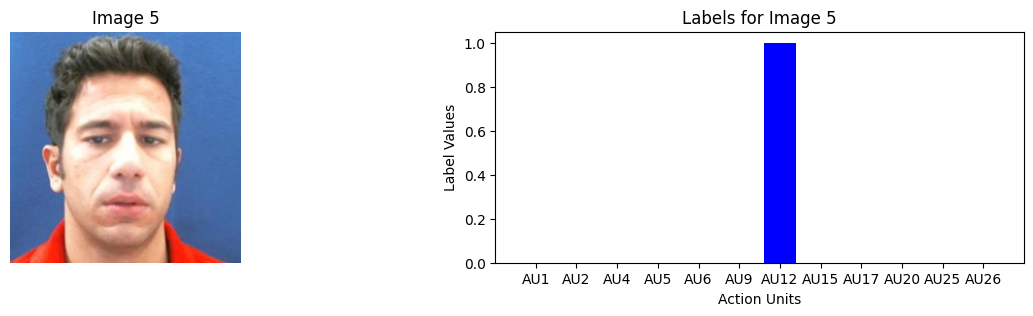

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Choose 5 random indices for displaying images
indices_to_display = np.random.choice(X.shape[0], 5, replace=False)

# Define labels
labels = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26']

# Plotting images with corresponding labels
for i, idx in enumerate(indices_to_display):
    image = X[idx].permute(1, 2, 0).numpy()  # Convert from PyTorch tensor to NumPy array
    label_values = Y[idx].tolist()

    plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(range(12), label_values, tick_label=labels, color='blue')
    plt.title(f"Labels for Image {i + 1}")
    plt.xlabel("Action Units")
    plt.ylabel("Label Values")
    plt.show()


In [7]:
Y.shape

torch.Size([6576, 12])

In [8]:
from torchvision.models import resnet18  # Import ResNet-18
from torch.nn import Linear
import torch.optim as optim  # Import the optimizer module

# Create a ResNet-18 model
model = resnet18(pretrained=True)  # Load pretrained ResNet-18

# Modify the classifier (fully connected) layer
n_features = model.fc.in_features
model.fc = Linear(n_features, 6)  # Assuming you have 6 classes

# Define the optimizer (e.g., SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


d:\anaconda\envs\TORCHGPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\TORCHGPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Using avalanche to train 

In [9]:
# add data transformations: (1) convert to tensor format, and (2) normalize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=180),
])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_trial, y_train, y_trial = train_test_split(X, Y, test_size=0.20, random_state=42)

In [11]:
from avalanche.benchmarks.utils import make_tensor_classification_dataset
trainds = make_tensor_classification_dataset(X_train, y_train)
testds = make_tensor_classification_dataset(X_trial, y_trial)

d:\anaconda\envs\TORCHGPU\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
d:\anaconda\envs\TORCHGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
y_trial.shape

torch.Size([1316, 12])

In [13]:
testds

_FlatDataWithTransform (len=1316,subset=False,cat=False,cf=True)
	_TensorClassificationDataset (len=1316)

In [14]:
trainds

_FlatDataWithTransform (len=5260,subset=False,cat=False,cf=True)
	_TensorClassificationDataset (len=5260)

In [15]:
from avalanche.benchmarks import ni_scenario
from avalanche.training.plugins import EvaluationPlugin
from avalanche.benchmarks.utils import make_tensor_classification_dataset
from avalanche.training.supervised import Naive, Replay, Cumulative
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics, disk_usage_metrics, cpu_usage_metrics, timing_metrics
from torch.optim import SGD

In [22]:
cl_scenario = ni_scenario(
    train_dataset=trainds,
    test_dataset=testds,
    n_experiences=1,
    seed=1234,
)

In [17]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [18]:
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'



cuda:0


In [23]:
# chossing the Naive strategy
cl_strategy = Naive(
    model,
    optimizer,
    torch.nn.CrossEntropyLoss(),
    train_mb_size=300,
    train_epochs=2,
    eval_mb_size=80,
    device=device
)

In [24]:
# Preparing a training plugin
evaluation = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    cpu_usage_metrics(experience=True),
    timing_metrics(),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
)

# here we add a plugin to the strategy
cl_strategy.evaluator = evaluation


In [25]:
results = []
for experience in cl_scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(cl_scenario.test_stream, num_workers=4))


Start of experience:  0
Current Classes:  [(0, 0, 0, 2, 0, 0, 4, 4, 5, 2, 2, 5), (5, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0), (5, 1, 0, 0, 5, 0, 5, 4, 0, 4, 0, 0), (0, 0, 0, 0, 0, 0, 5, 4, 5, 1, 3, 5), (0, 1, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0), (3, 4, 0, 0, 2, 3, 0, 0, 2, 2, 0, 0), (0, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0), (0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0), (0, 2, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0), (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (3, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0), (2, 5, 0, 0, 2, 0, 4, 2, 0, 1, 0, 0), (0, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0), (2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0), (1, 0, 5, 3, 0, 0, 0, 0, 1, 2, 0, 0), (0, 0, 0, 1, 0, 0, 4, 5, 5, 2, 2, 5), (0, 0, 0, 3, 0, 0, 4, 4, 5, 1, 2, 5), (0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 3, 0, 0, 4, 4, 4, 0, 3, 5), (1, 1, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0), (0, 3, 0, 0, 0, 2, 4, 0, 5, 0, 0, 0), (0, 2, 0, 0, 0, 0, 4, 1, 0, 0, 1, 0), (5, 0, 0, 0, 4, 0, 1, 0, 2, 2, 0, 0), (0, 0, 4, 2, 0, 0, 3, 0, 2, 0, 4, 3), (3, 0, 

KeyboardInterrupt: 